# Project milestone 4
# Detection of housing-health relationship


The aim of this project is to estimate the relation between housing quality and health status of a person. The project is an observational study based on a survey made by Mexican National Institute of Statistics and Geography in 2017 ([National Household Survey 2017](https://en.www.inegi.org.mx/programas/enh/2017/#Microdata)). The health variables reported for each person will be used to define a single health variable which will be a score for each person's health status. We aim to use machine learning methods to do the classification and we will use regression models to predict this health score from the housing variables. Matching will be used to weed out the possible covariates. The motivation is to estimate the most important parameters of housing quality so that we can propose most cost-effective solutions that would increase the quality of health. The original paper is based on the analysis of influence of concrete floors on health quality, while here we would investigate some other parameters such as material used for building and whether there is a toilet or not in the household.

# Step 1: Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In this section, we load the translated headers (from spanish to english) and the datasets. We verified that the number of entries correspond to the [File Descriptor FD](https://en.www.inegi.org.mx/app/biblioteca/ficha.html?upc=702825101725) provided by INEGI. Note that we will use the word *person* instead of *member* as a translation to *persona* because we consider it is a better translation.

In [2]:
# Load the translated headers
vivienda_header_trans = pd.read_csv('./data/translated_house.txt', squeeze=True, header =None)
hogar_header_trans = pd.read_csv('./data/translated_household.txt', squeeze=True, header=None)
persona_header_trans = pd.read_csv('./data/translated_person.txt', squeeze=True, header=None)

# Load the datasets with the translated headers
data_housing = pd.read_csv('./data/vivienda.csv', skiprows=1, names=vivienda_header_trans, low_memory=False)
data_household = pd.read_csv('./data/hogar.csv', skiprows=1, names=hogar_header_trans, low_memory=False)
data_person = pd.read_csv('./data/persona.csv', skiprows=1, names=persona_header_trans, low_memory=False)

print('vivienda.csv shape: {}'.format(data_housing.shape))
print('hogar.csv shape: {}'.format(data_household.shape))
print('persona.csv shape: {}'.format(data_person.shape))

vivienda.csv shape: (56680, 110)
hogar.csv shape: (57519, 13)
persona.csv shape: (208140, 58)


The [File Descriptor FD](https://en.www.inegi.org.mx/app/biblioteca/ficha.html?upc=702825101725) tell us that for each housing, there can be more that one households and for each household, there can be more than one person. We use these the information to merge first `data_housing` into `data_household` and then into `data_person`.

In [3]:
# Merge the data on the 'house_identifier column'
data_household_all = data_household.merge(data_housing, on='housing_identifier')
data_person_all = data_person.merge(data_household_all, on=['housing_identifier', 'household_identifier'])

print('data_person_all shape: {}'.format(data_person_all.shape))
data_person_all.sample(10)

data_person_all shape: (208140, 178)


,housing_identifier,household_identifier,person_identifier,age,birthday,birth_month,sex,relationship,school_attendance,school_type,...,pay_tv_service_availability,availability_of_own_car,total_households_in_the_dwelling,geographic_location,basic_geostatistical_area,location_size,socioeconomic,sample_design_stratum,primary_sampling_unit,expansion_factor
54693,916097098,1,2,57,29,07,2,2,2,,...,2,1,1,90130000,000-0,1,2,80,2460,1441
51698,905245083,1,14,13,15,09,2,4,1,1,...,2,2,1,90050000,000-0,1,2,80,2271,1252
62865,1100015111,1,4,13,06,12,1,3,1,1,...,2,2,1,110070000,000-0,1,2,100,2841,536
137247,2201192051,1,1,43,15,09,1,1,2,,...,1,1,1,220140000,000-0,1,2,232,5457,306
120320,1909100094,1,3,25,24,03,2,3,2,,...,2,1,1,190480000,000-0,1,2,194,4932,745
130241,2102769075,1,2,37,09,04,2,2,2,,...,2,2,1,211140000,000-0,1,2,218,5218,964
43231,761771134,1,5,29,16,11,1,3,2,,...,2,2,1,70740000,000-0,4,1,65,1845,1207
113153,1801599108,1,2,50,02,05,2,2,2,,...,2,2,1,180150000,000-0,3,2,180,4613,217
58294,1001355133,1,4,16,11,05,1,3,2,,...,2,2,1,100050000,000-0,1,3,91,2702,265
148723,2400008044,1,2,26,25,12,2,2,2,,...,1,1,1,240130000,000-0,1,2,256,5950,405


# Step 2: Exploratory Data Analysis
## Health variables
We chose as our health variables the following ones. We drop other health related variables because they were not correctly filled and most of the answer were empty (e.g. `['walking_apparatus', 'intensity_of_nervousness', 'intensity_of_depression', 'pain_intensity', 'intensity_of_fatigue', 'tired_time']`). However the information is still present in the chosen ones.

In [4]:
health_var = ['wear_glasses', 'difficulty_seeing', 'wear_a_hearing_aid','difficulty_hearing',
                'difficulty_hearing_without_noise','difficulty_hearing_with_noise', 'dificulty_to_walk',
                'use_a_walking_device', 'difficulty_walking_100_m', 'difficulty_walking_500_m',
                'difficulty_climbing_12_steps_', 'difficulty_remembering','frequency_of_nervousness',
                'medication_for_nervousness', 'frequency_of_depression', 'antidepressant_medications',
                'frequency_of_pain', 'fatigue_frequency']

## Cleaning and guidelines
Besides cleaning the data (e.g. replacing empty values), we will change the labels of the variables according to the following criteria in order to ensure consistency with health and have better properties for the regression.
* 0 - when the variable suggest a healthy person.
* 1 or greater - when the variable suggest a health issue (in increasing order).
* nan - when there is no answer.


In [5]:
# Cleaning
data_person_all = data_person_all.replace(' ', np.nan)
data_person_all = data_person_all.replace('&', np.nan)
data_person_all = data_person_all.replace('9', np.nan)

We drop all the rows where there is not complete information of the health variables since we lost around 14% of the data but don't do any assumption.

In [6]:
# Drop nan rows for the health_var (i.e. work only with rows with complete information)
data_person_all = data_person_all.dropna(subset=health_var)
data_person_all.shape

(179072, 178)

In [7]:
# Transform from strings to numbers
data_person_all[health_var] = data_person_all[health_var].apply(pd.to_numeric)
data_person_all[health_var].dtypes

wear_glasses                        int64
difficulty_seeing                   int64
wear_a_hearing_aid                  int64
difficulty_hearing                  int64
difficulty_hearing_without_noise    int64
difficulty_hearing_with_noise       int64
dificulty_to_walk                   int64
use_a_walking_device                int64
difficulty_walking_100_m            int64
difficulty_walking_500_m            int64
difficulty_climbing_12_steps_       int64
difficulty_remembering              int64
frequency_of_nervousness            int64
medication_for_nervousness          int64
frequency_of_depression             int64
antidepressant_medications          int64
frequency_of_pain                   int64
fatigue_frequency                   int64
dtype: object

In order to flip the grading of the variables, where the lowest value reflects a health issue, we verify that each column has a maximum value corresponding to the [File Descriptor FD](https://en.www.inegi.org.mx/app/biblioteca/ficha.html?upc=702825101725). This allows us to multiply each column by -1 and substract the maximum of the column.

In [8]:
# Variables where we flip the grading for consistency in the grading.
flipped_var = ['wear_glasses', 'wear_a_hearing_aid', 'use_a_walking_device', 'frequency_of_nervousness',
                'medication_for_nervousness', 'frequency_of_depression', 'antidepressant_medications'] 

# Verify that each column has the correct maximum possible value. 
data_person_all[flipped_var].max(axis=0)

# Substract one from all the columns and flip the grading for the flipped var
data_person_all[health_var] = data_person_all[health_var] - 1
data_person_all[flipped_var] = data_person_all[flipped_var]*-1 + data_person_all[flipped_var].max(axis=0)

display(data_person_all[health_var].max(axis=0))
display(data_person_all[health_var].min(axis=0))

wear_glasses                        1
difficulty_seeing                   3
wear_a_hearing_aid                  1
difficulty_hearing                  2
difficulty_hearing_without_noise    2
difficulty_hearing_with_noise       3
dificulty_to_walk                   3
use_a_walking_device                1
difficulty_walking_100_m            2
difficulty_walking_500_m            3
difficulty_climbing_12_steps_       3
difficulty_remembering              3
frequency_of_nervousness            4
medication_for_nervousness          1
frequency_of_depression             4
antidepressant_medications          1
frequency_of_pain                   3
fatigue_frequency                   3
dtype: int64

wear_glasses                        0
difficulty_seeing                   0
wear_a_hearing_aid                  0
difficulty_hearing                  0
difficulty_hearing_without_noise    0
difficulty_hearing_with_noise       0
dificulty_to_walk                   0
use_a_walking_device                0
difficulty_walking_100_m            0
difficulty_walking_500_m            0
difficulty_climbing_12_steps_       0
difficulty_remembering              0
frequency_of_nervousness            0
medication_for_nervousness          0
frequency_of_depression             0
antidepressant_medications          0
frequency_of_pain                   0
fatigue_frequency                   0
dtype: int64

In [9]:
# See all the ranges
for var in health_var:
    print('{}\t{}'.format(var, data_person_all[var].unique()))

wear_glasses	[1 0]
difficulty_seeing	[0 2 1 3]
wear_a_hearing_aid	[0 1]
difficulty_hearing	[1 0 2]
difficulty_hearing_without_noise	[1 0 2]
difficulty_hearing_with_noise	[1 0 2 3]
dificulty_to_walk	[1 0 2 3]
use_a_walking_device	[1 0]
difficulty_walking_100_m	[0 1 2]
difficulty_walking_500_m	[0 2 3 1]
difficulty_climbing_12_steps_	[2 0 1 3]
difficulty_remembering	[0 2 1 3]
frequency_of_nervousness	[1 4 3 0 2]
medication_for_nervousness	[0 1]
frequency_of_depression	[3 2 0 1 4]
antidepressant_medications	[0 1]
frequency_of_pain	[1 0 3 2]
fatigue_frequency	[1 0 2 3]


### Creation of health variable

Given the high number of health related variables present in our dataset, we decided to condense all of them in just one variable ranging from 0 to 18, with 18 being the "healthiest" score which also corresponds to number of health variables we selected in the dataset. To obtain this score we first consider every health variable independently, we derive its set of possible values and for each of this values we derive the proportion of people in the dataset that have a value equal or lower divided by the number of elements in the dataset( given the structure of the original database we reverse the order in this operation). We then substituted those new values in the dataset and added them to obtain the final score.

In [10]:
data_person_all[health_var] = 1 - data_person_all[health_var] / data_person_all[health_var].max(axis=0)
data_person_all['health'] =  data_person_all[health_var].sum(axis=1)

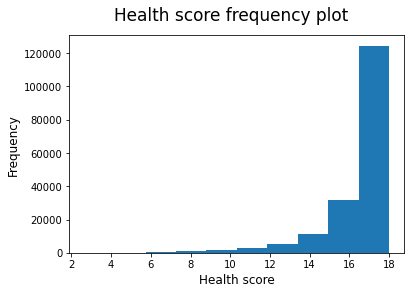

In [11]:
# distribution of "health" in the dataset
fig, ax = plt.subplots()
ax.set_xlabel('Health score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
fig.suptitle("Health score frequency plot", fontsize=17)
data_person_all["health"].hist(ax=ax,bins=10)
ax.grid(False)

In [12]:
# Uniform Health Scores
health_var.append('health')
for item in health_var:
    # Sort by score
    sorted_h=data_person_all[item].sort_values(ascending=False)
    sorted_h_length=len(sorted_h)

    score_ar=np.empty(sorted_h_length)

    score=100
    old_row=100
    counter=0

    for index, row in sorted_h.items():
        # To have same uniform score for person with same old health score
        if row<old_row:
            score=100-100*counter/sorted_h_length
        score_ar[counter]=score
        old_row=row
        counter+=1

    sc_pand=pd.Series(score_ar)
    # Use old index
    sc_pand.index=sorted_h.index
    # Unsort to original
    sc_pand=sc_pand.sort_index()
    data_person_all[item]=sc_pand

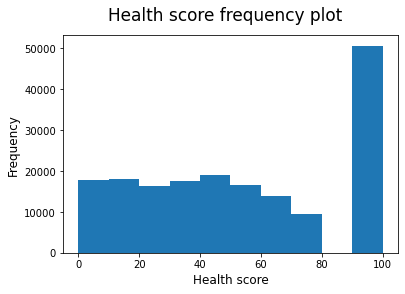

In [13]:
# distribution of "health" in the dataset
fig, ax = plt.subplots()
ax.set_xlabel('Health score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
fig.suptitle("Health score frequency plot", fontsize=17)
data_person_all["health"].hist(ax=ax,bins=10)
ax.grid(False)

# Step 3: Preliminary data analysis

## Explore data house-health relation of boolean variables
In following four figures we present the relation between four house variables and health variables. The habitant of the house were quesioned whether the house is in need for a certain repair. They could either answer yes or no to these questions. Slight difference between these to groups is observed. One can see that in most of the cases house with need for a repair (blue bars) exhibit slightly lower values of health score. One has to have in mind that the distribution of health score is imbalanced across the population since most of the population is healthy so even a slight difference in health score could be important. In further analysis we will try to answer whether this difference is statisticaly significant. Interestignly it seems that people in badly maintaned houses seems to be less depressed and nervous.

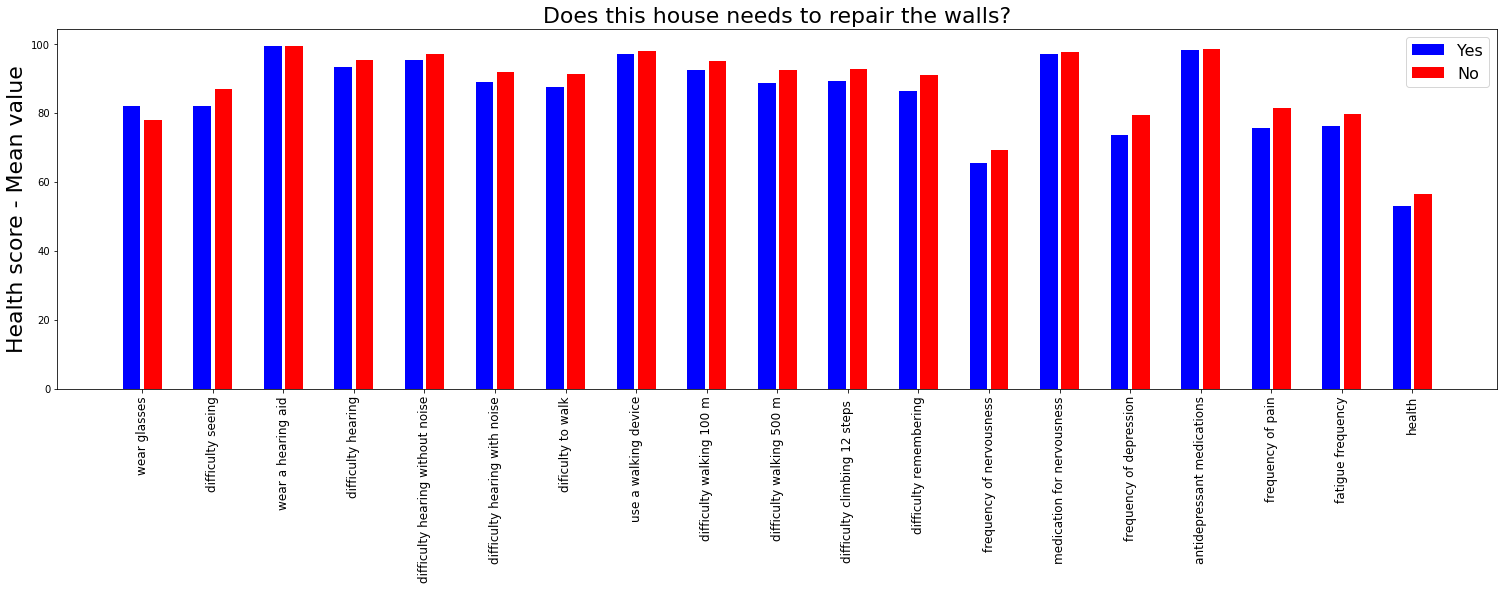

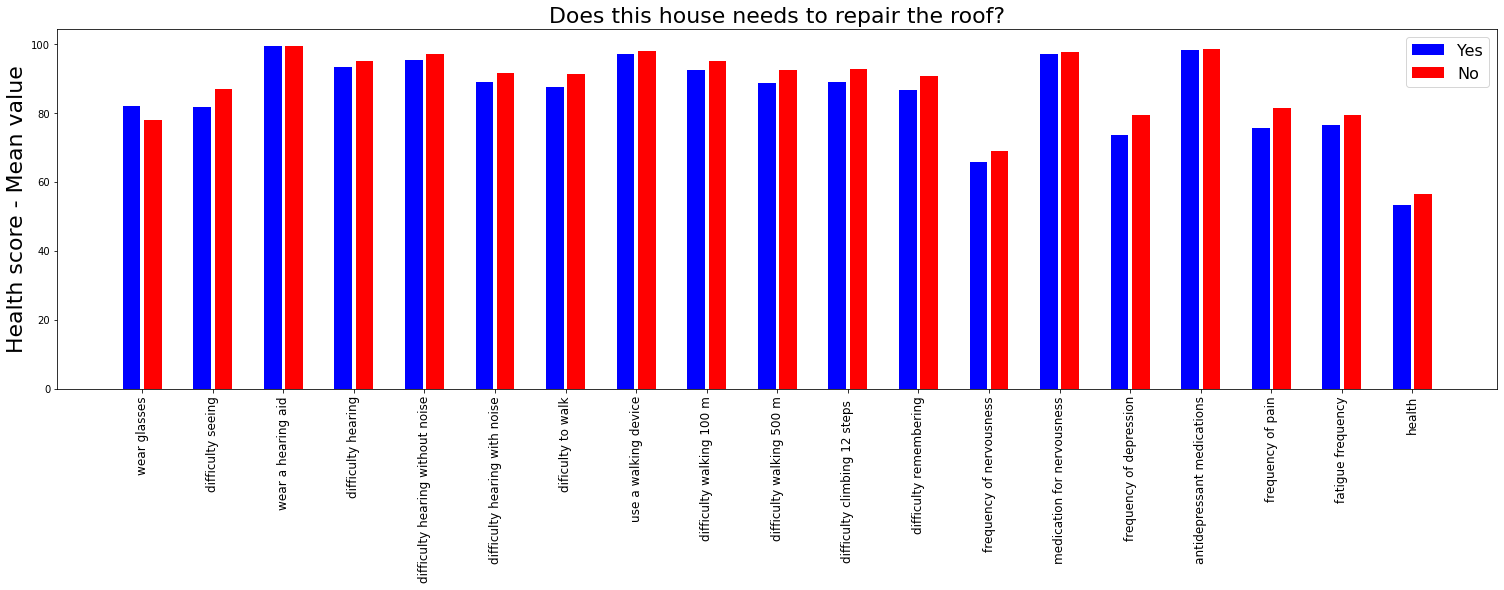

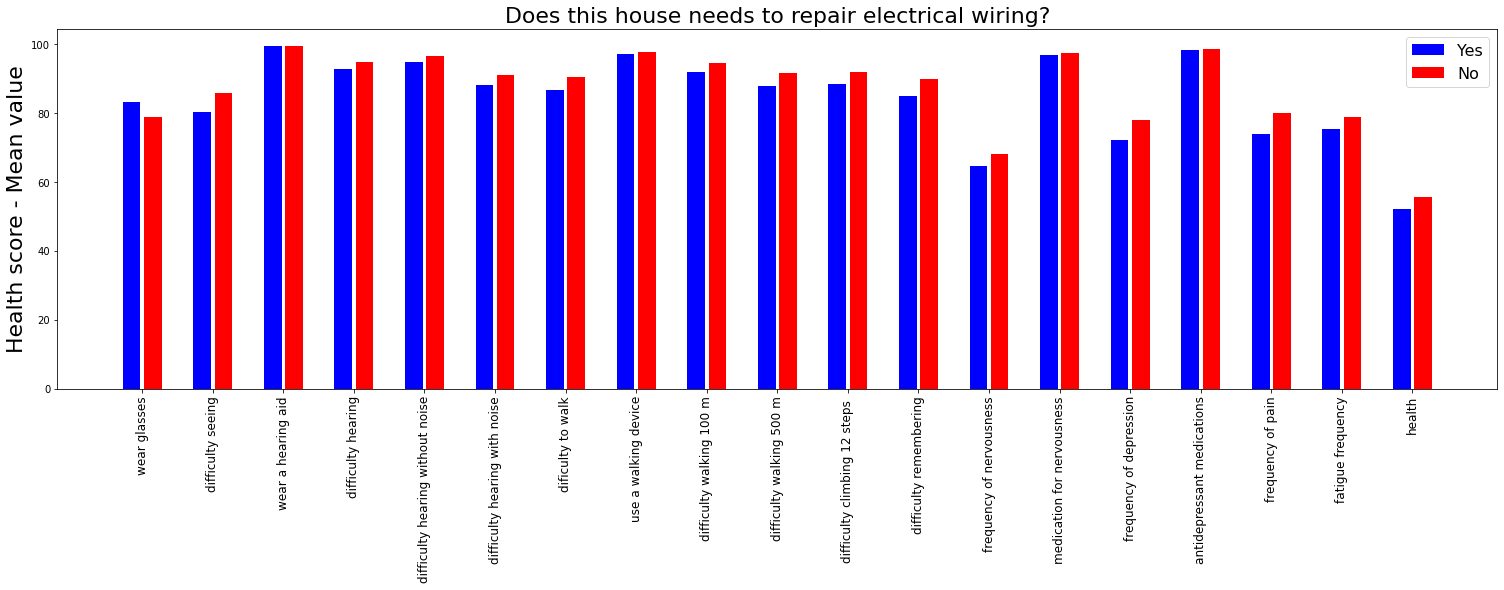

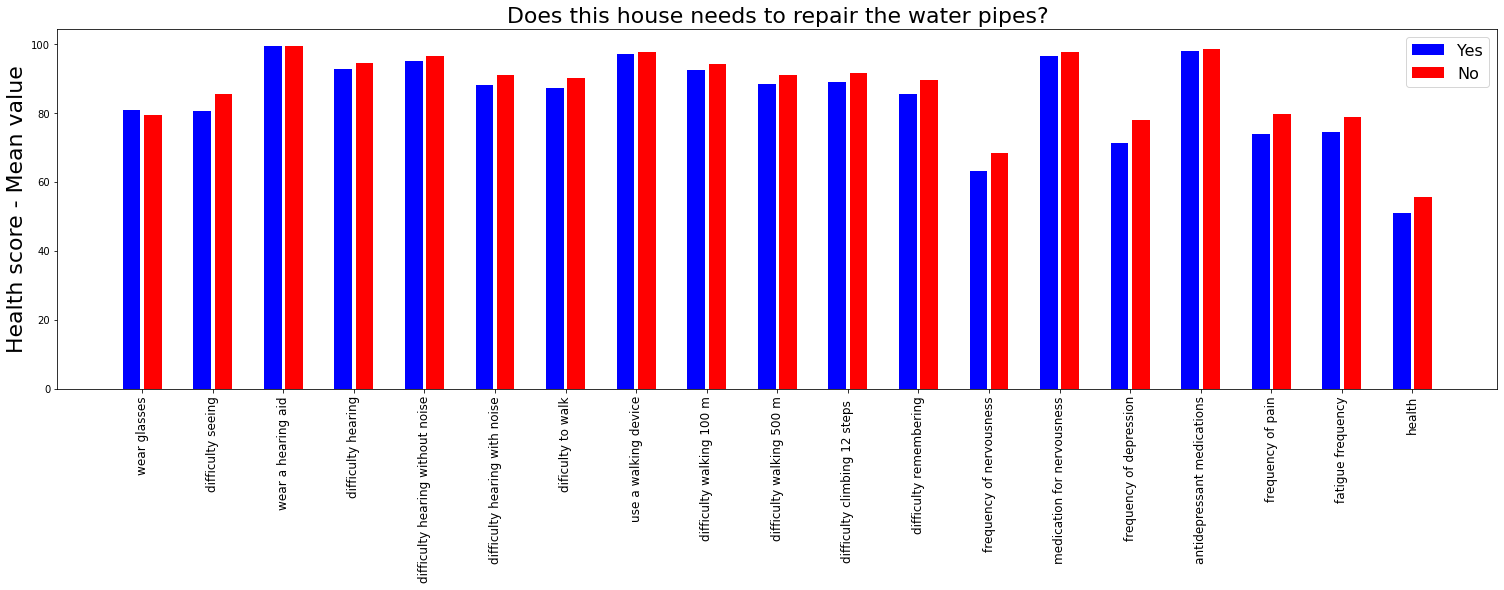

In [14]:
important_house_var = ['repair_the_walls', 'repair_the_roof', 'repair_electrical_wiring', 'repair_the_water_pipes']
health_var_txt = [x.replace('_',' ') for x in health_var ]

for house_item in important_house_var:
    mask = data_person_all[house_item]==1
    data_yes = data_person_all[mask]
    data_no = data_person_all[~mask]

    datay = data_yes[health_var].mean().values
    datax = data_no[health_var].mean().values

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_axes([0,0,1,1])
    
    x = np.arange(len(health_var))  # the label locations
    width = 0.3  # the width of the bars

    for item in health_var:
        ax.bar(x - width/2, datay, color = 'b', width = 0.25)
        ax.bar(x + width/2, datax, color = 'r', width = 0.25)
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='90',fontsize=12)
        ax.legend(labels=['Yes', 'No'],fontsize=16)
    plt.title('Does this house needs to '+house_item.replace('_',' ').lower()+'?',fontsize=22)
    plt.ylabel('Health score - Mean value',fontsize=22)

    

## Building materials vs Health

We now explore the relationship between roofing and flooring materials and the health variables.

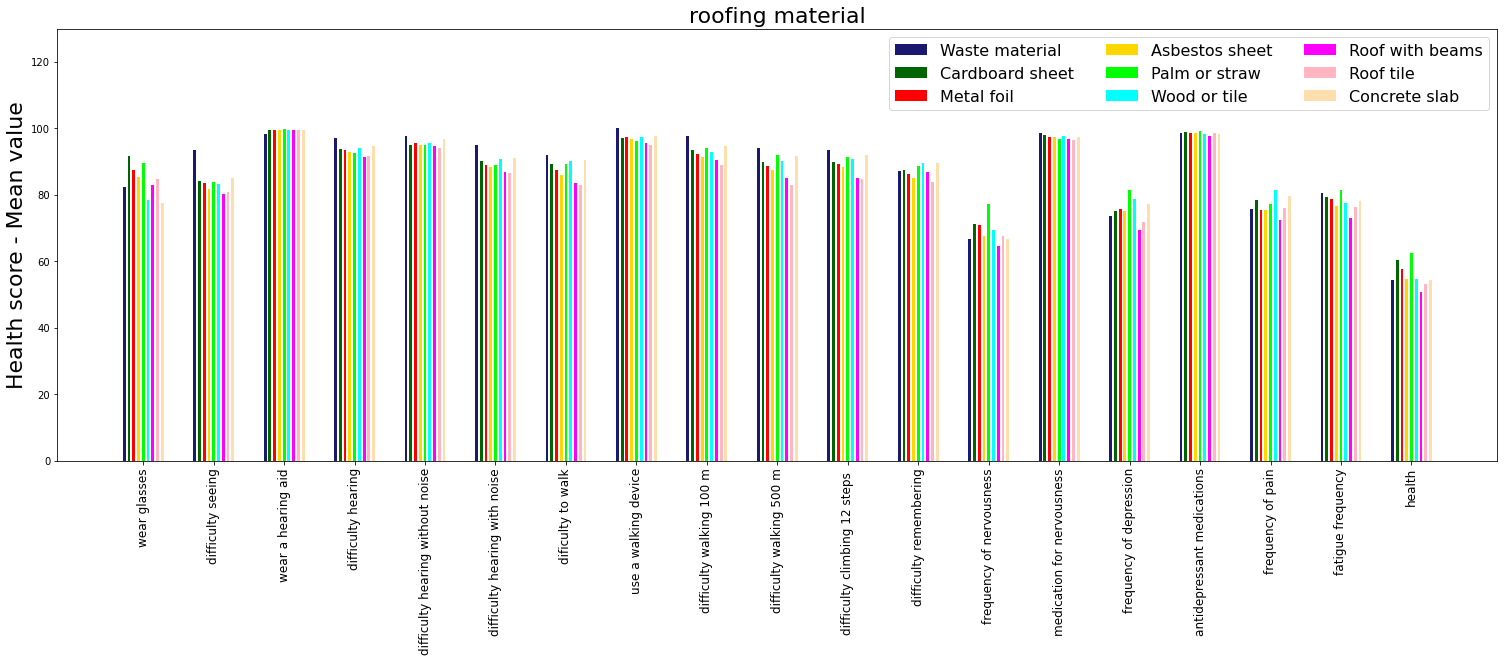

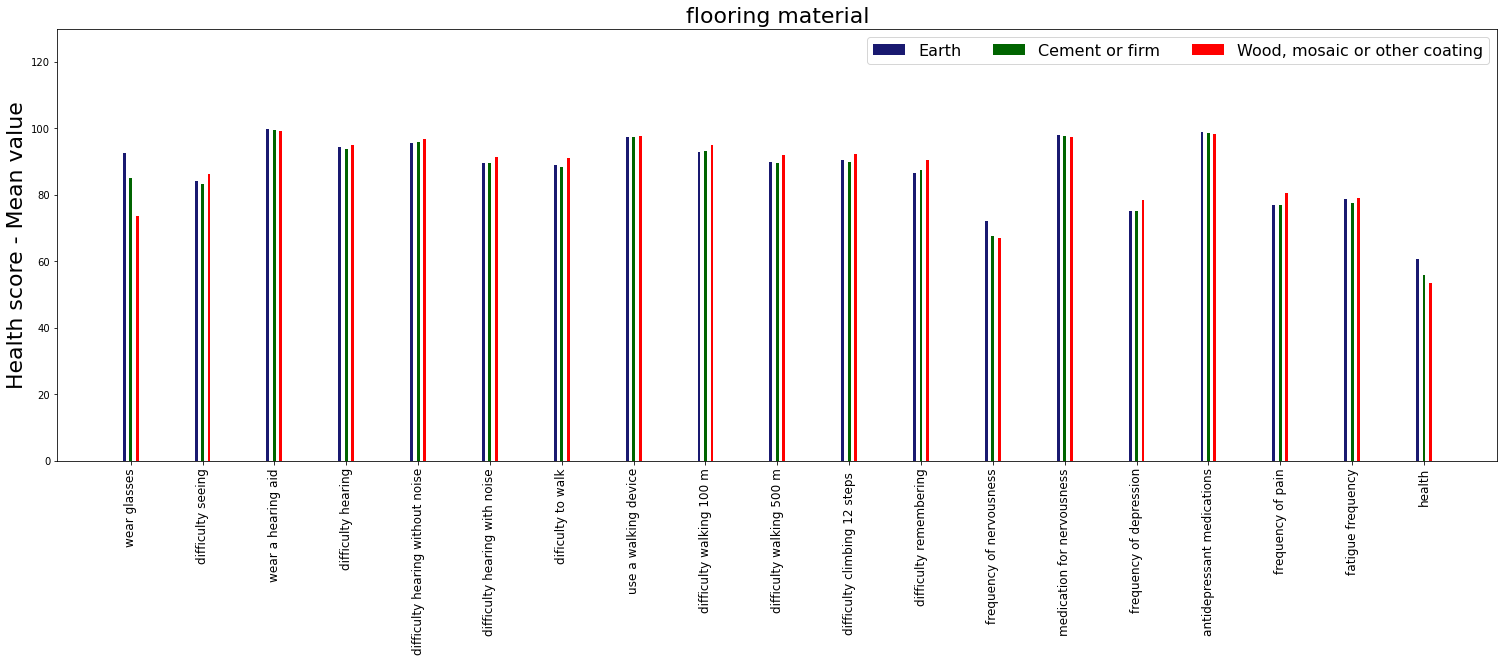

In [16]:
house_material=['roofing_material','flooring_material']
mat = [None] *2
mat[0]=['Waste material' ,'Cardboard sheet' ,'Metal foil','Asbestos sheet' ,'Palm or straw' ,'Wood or tile ','Roof with beams', 'Roof tile', 'Concrete slab' ]
mat[1]=['Earth', 'Cement or firm', 'Wood, mosaic or other coating']

for index_global,house_item in enumerate(house_material):
    answers=sorted(data_person_all[house_item].value_counts().index)
    len_answers=num=len(answers)
    
    data = [None] * len_answers
    for index,item in enumerate(answers):
        data[index]=data_person_all[data_person_all[house_item]==answers[index]][health_var].mean()
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_axes([0,0,1,1])
    
    x = np.arange(len(health_var))  # the label locations
    width = 0.06  # the width of the bars
    width_vector=np.linspace(start=-width*len_answers/2, stop=width*len_answers/2,num=len_answers )
    color_list=['#191970', '#006400', '#ff0000', '#ffd700', '#00ff00' ,'#00ffff','#ff00ff' ,'#ffb6c1','#ffdead']
    
    for item in health_var:
        for index,wid in enumerate(width_vector):
            ax.bar(x + wid, data[index], width = 0.04,color=color_list[index])
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='90',fontsize=12)
        ax.legend(labels=mat[index_global],fontsize=16,ncol=3)
    plt.ylim(0,130)
    plt.title(house_item.replace('_',' '),fontsize=22)
    plt.ylabel('Health score - Mean value',fontsize=22)


Now we are going to analyze if the relantionship between wearing glasses and flooring material is statistically significant in our dataset using a Fisher Exact test.

In [17]:
# fisher exact test
import scipy.stats as stats
# given the previous transformation of the variable wera_glasses now we have that it's value is 100 for those who do not 
# wear glasses, while it is 28 for those who wear them.
n1 = len(data_person_all[(data_person_all["wear_glasses"]>50) & (data_person_all["flooring_material"]=="1")])
n3 = len(data_person_all[(data_person_all["wear_glasses"]>50) & (data_person_all["flooring_material"]=="2")])
n2 = len(data_person_all[(data_person_all["wear_glasses"]<=50) & (data_person_all["flooring_material"]=="1")])
n4 = len(data_person_all[(data_person_all["wear_glasses"]<=50) & (data_person_all["flooring_material"]=="2")])
_ , pvalue = stats.fisher_exact([[n1, n2], [n3, n4]])
pvalue

9.36211640441411e-63

The table represents in the first column the number of those who wear glasses, second one the number of those who don't wear them. The first row the number of those who have earth as flooring material, second row is cement or firm. The probability of getting such combination by chance is "practically" zero therefore we found an observational relantionship between the two variables, it is only observational (and was not proven casual) because there could be hidden cofactors that influence it such as economic disparity.

## Cell phone availability vs health

Text(0, 0.5, 'Health score - Mean value')

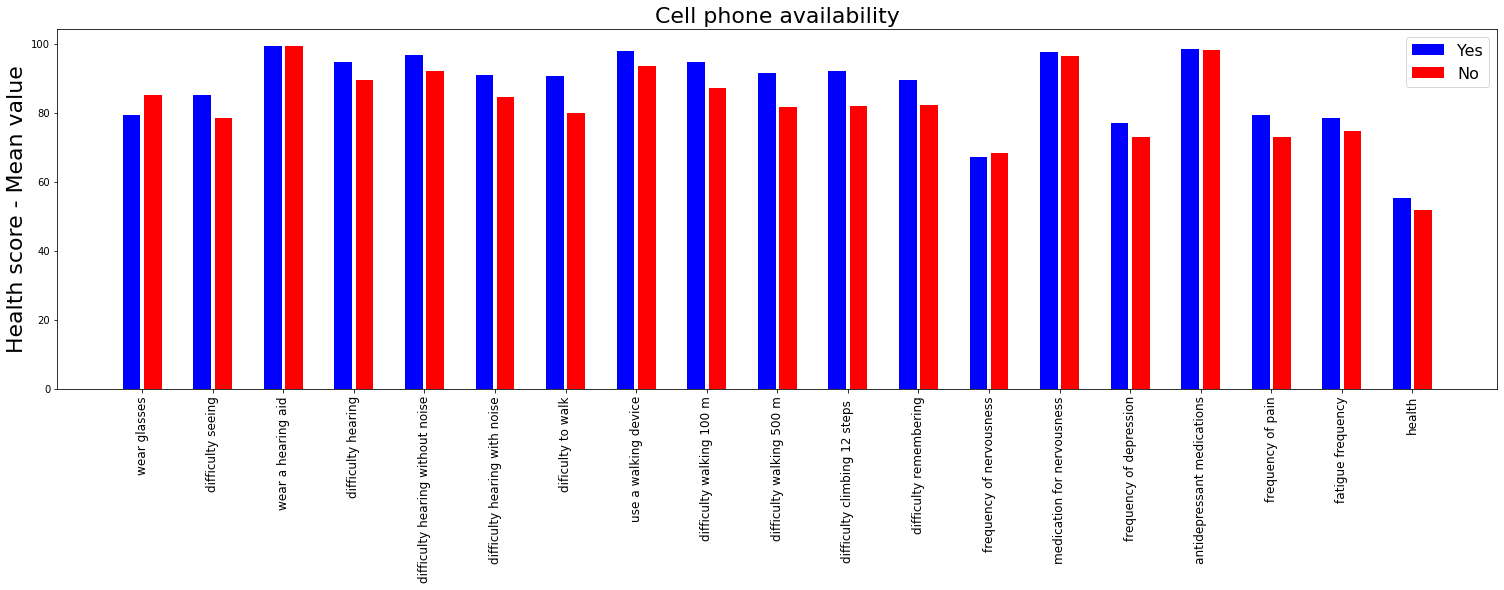

In [18]:
mask=data_person_all['cell_phone_availability']==1
data_yes=data_person_all[mask]
data_no=data_person_all[~mask]

datay=data_yes[health_var].mean().values
datax=data_no[health_var].mean().values

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
    
x = np.arange(len(health_var))  # the label locations
width = 0.3  # the width of the bars

for item in health_var:
        ax.bar(x - width/2, datay, color = 'b', width = 0.25)
        ax.bar(x + width/2, datax, color = 'r', width = 0.25)
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='90',fontsize=12)
        ax.legend(labels=['Yes', 'No'],fontsize=16)
plt.title('Cell phone availability',fontsize=22)
plt.ylabel('Health score - Mean value',fontsize=22)

## Age of person vs health

We now compare our health score with the variable age in the dataset. As expected the health score is decreasing with the age.

Text(0, 0.5, 'Total health score - Mean ')

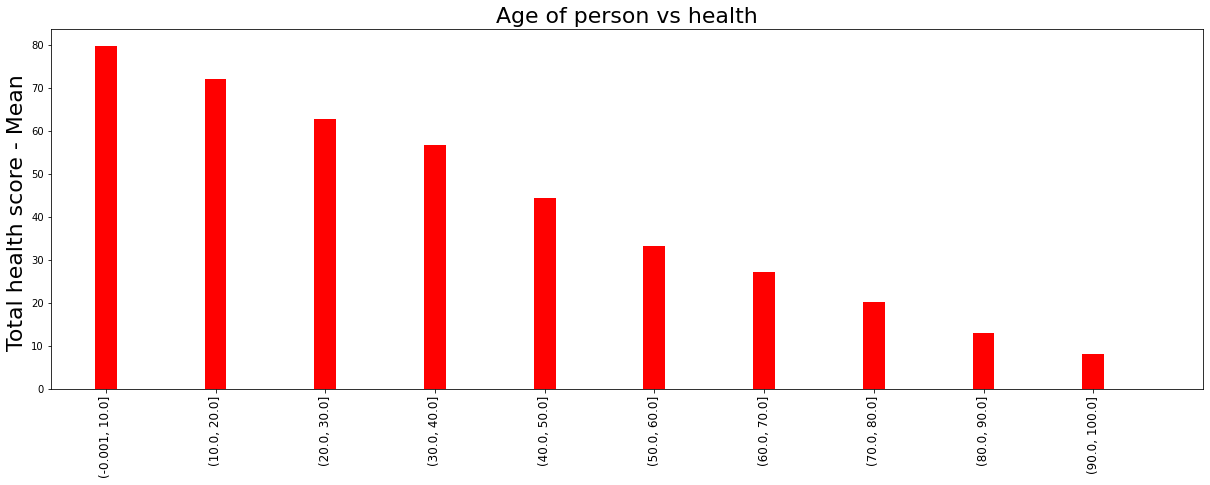

In [19]:
data_person_all['age_cat']=pd.cut(data_person_all['age'], bins=[0,10,20,30,40,50,60,70,80,90,100], include_lowest=True)
answers=sorted(data_person_all['age_cat'].value_counts().index)
len_answers=len(answers)
means = [None] *len_answers
for index,item in enumerate(answers):
    means[index]=data_person_all[data_person_all['age_cat']==item]['health'].mean()

fig= plt.figure(figsize=(16,5))
ax = fig.add_axes([0,0,1,1])    
x = np.arange(len_answers)  # the label locations
width = 0.3  # the width of the bars

ax.bar(x, means, color = 'r', width = 0.2)
plt.xlim(-0.5,10)
ax.set_xticks(x)
ax.set_xticklabels(answers,rotation='90',fontsize=12)

plt.title('Age of person vs health',fontsize=22)
plt.ylabel('Total health score - Mean ',fontsize=22)


The decreasing trend in health is clear, it is also expected since older people are usually less healthy.

# Step 4: Linear Regression

### Fill response variables

In [20]:
data_person_all["health"].describe()

count    179072.000000
mean         54.833084
std          33.697276
min           0.000558
25%          25.034623
50%          50.967767
75%         100.000000
max         100.000000
Name: health, dtype: float64

In [21]:
# To run for all health_var or for health score
response='health'

### Pearson correlation
In order to limit the number of analyzed variables and to select the most important features, we calculate Person correlation coefficient. 

In [22]:
health_var.append('health')
covariates=list(data_person_all.columns)
covariates = [x for x in covariates if not x in health_var]

In [23]:
pearson_result=data_person_all[covariates].corrwith(data_person_all['health'], axis=0, method='pearson')
pearson_result=pearson_result.reindex(pearson_result.abs().sort_values(ascending=False).index)
#for val in pearson_result.items():
    #print(val)
covariates_top=pearson_result.index[0:25];

### Fill model with all variables

In our first regression model we used as predictor variables our health score previously generated, as predictor variables we considered only those derived from the data housing dataset. 

In [24]:
model1='~'
cat_list=['relationship','type_of_home_ownership', 'flooring_material', 'roofing_material', 'socioeconomic' ,'location_size', 'fuel_type']

for index,item in enumerate(covariates_top):
    # First regression model with household variables only
    if item not in data_housing.columns:
        continue
    if index<1:
        model1=model1+item
    else:
        if data_person_all[item].value_counts().count()==2 or item in cat_list:
            model1=model1+'+'+'C('+item+')'
        else:
            model1=model1+'+'+item
            # Standardize the countinuous variables
            data_person_all[item] = (data_person_all[item] - data_person_all[item].mean())/data_person_all[item].std()
                
model1

'~+C(fixed_telephone_line_availability)+C(it_has_a_gas_heater_for_water)+C(socioeconomic)+C(build_bedroom)+C(it_has_a_sink)+C(fuel_type)+C(location_size)+C(repair_the_water_pipes)+C(it_has_a_shower)+C(living_room_space)+C(it_has_a_water_tank)+C(repair_the_walls)+drainage_destination+water_availability+bedroom_rooms+C(repair_the_roof)+C(it_has_a_stationary_gas_tank)+C(it_has_a_water_pump)'

In our second regression model we used as predictor variables our health score previously generated, as predictor variables we considered all the variables present in the house and person dataset.

In [25]:
# Second regression model with control person variables as well
model2='~'
for index,item in enumerate(covariates_top):
    if index<1:
        model2=model2+item
    else:
        if data_person_all[item].value_counts().count()==2 or item in cat_list:
            model2=model2+'+'+'C('+item+')'
        else:
            model2=model2+'+'+item
            # Standardize the countinuous variables
            data_person_all[item] = (data_person_all[item] - data_person_all[item].mean())/data_person_all[item].std()     
model2

'~age+person_identifier+C(relationship)+number_of_household_members+total_male_members+total_female_members+C(sex)+C(fixed_telephone_line_availability)+C(it_has_a_gas_heater_for_water)+C(socioeconomic)+C(build_bedroom)+C(it_has_a_sink)+C(fuel_type)+C(location_size)+C(repair_the_water_pipes)+C(it_has_a_shower)+C(living_room_space)+C(it_has_a_water_tank)+C(repair_the_walls)+drainage_destination+water_availability+bedroom_rooms+C(repair_the_roof)+C(it_has_a_stationary_gas_tank)+C(it_has_a_water_pump)'

In [26]:
# Fits the model1 and model2 (find the optimal coefficients, adding a random seed ensures consistency)
res=[None,None]
np.random.seed(1950)

for i,model in enumerate([model1,model2]):
    mod= smf.ols(formula=response+model, data=data_person_all,missing='raise')
    res[i] = mod.fit()

In [27]:
variables=[None,None]
coefficients=[None,None]
p_values=[None,None]
standard_errors=[None,None]
for i in range(2):
    # feature names
    variables[i] = res[i].params.index
    # quantifying uncertainty!
    # coefficients
    coefficients[i] = res[i].params.values
    # p-values
    p_values[i] = res[i].pvalues
    # standard errors
    standard_errors[i] = res[i].bse.values


In [28]:
l1=[None,None];l2=[None,None];l3=[None,None];l4=[None,None];
for i in range(2):
    #sort them all by coefficients
    l1[i], l2[i], l3[i], l4[i] = zip(*sorted(zip(coefficients[i][1:], variables[i][1:], standard_errors[i][1:], p_values[i][1:])))

    # in this case, we index starting from the first element, not to plot the intercept

    # we will use standard errors, instead of CIs
    # two standard errors approximate the CIs (you can actually see in the summary table that
    # +/2 SI is equivalent to the CIs)

    # Edit l2
    l2[i]=[x.replace('_',' ') for x in l2[i] ]

## Regression resluts
We plot the resulsting coefficents with intervals showing +-2 standard errors. The coefficent are sorted in the descending order.

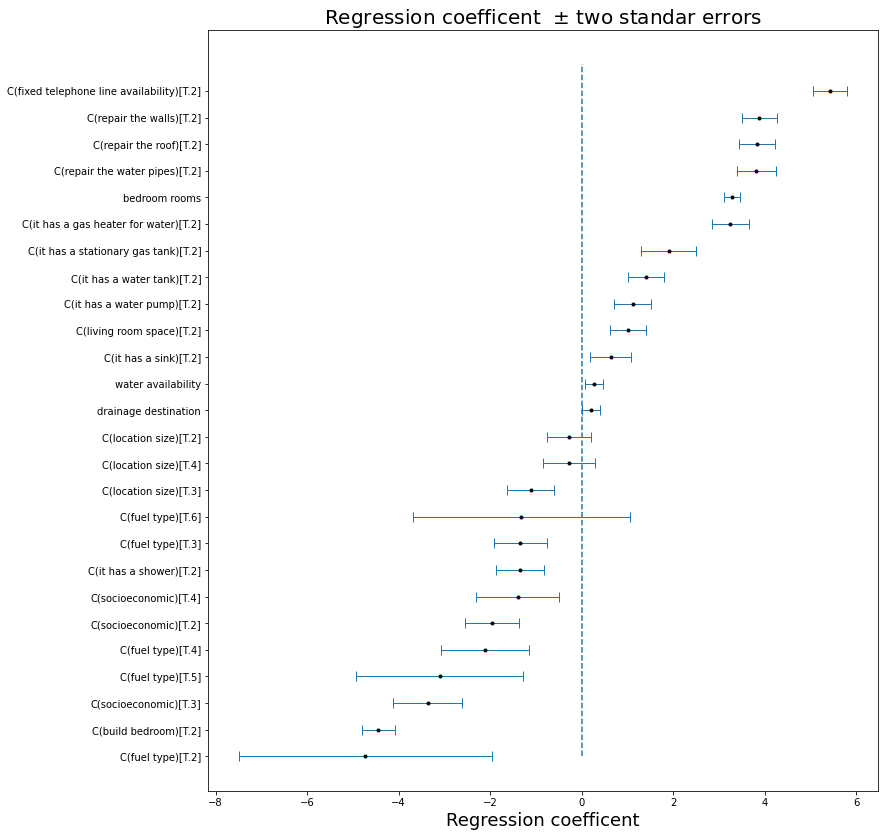

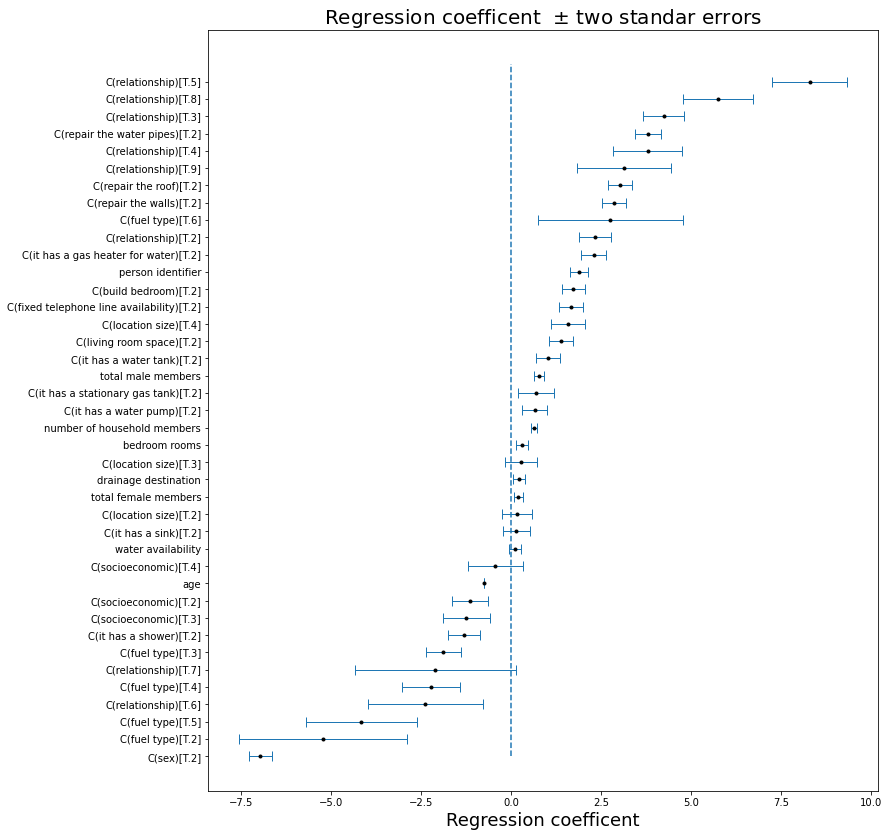

In [29]:
for i in range(2):
    # Plotting
    plt.figure(figsize=(12,14))
    plt.errorbar(l1[i], np.array(range(len(l1[i]))), xerr= 2*np.array(l3[i]), linewidth = 1,
                 linestyle = 'none',marker = 'o',markersize= 3,
                 markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1[i]), linestyle = '--')

    plt.yticks(range(len(l2[i])),l2[i]);
    plt.title('Regression coefficent  $\pm$ two standar errors',fontsize=20)
    plt.xlabel('Regression coefficent',fontsize=18)

In [30]:
indexes=[]
for i,item in enumerate(l2[1]):
    if item in l2[0]:
        continue
    else:
        indexes.append(i)
l1[1]=list(l1[1]);l2[1]=list(l2[1]);l3[1]=list(l3[1]);l4[1]=list(l4[1]);

for index in sorted(indexes, reverse=True):
    del l1[1][index]
    del l2[1][index]
    del l3[1][index]
    del l4[1][index]

In [31]:
# Reorder both models in same order
myorder=[l2[1].index(x) for x in l2[0]]
l2[1] = [l2[1][i] for i in myorder];l1[1] = [l1[1][i] for i in myorder];l3[1] = [l3[1][i] for i in myorder];l4[1] = [l4[1][i] for i in myorder];

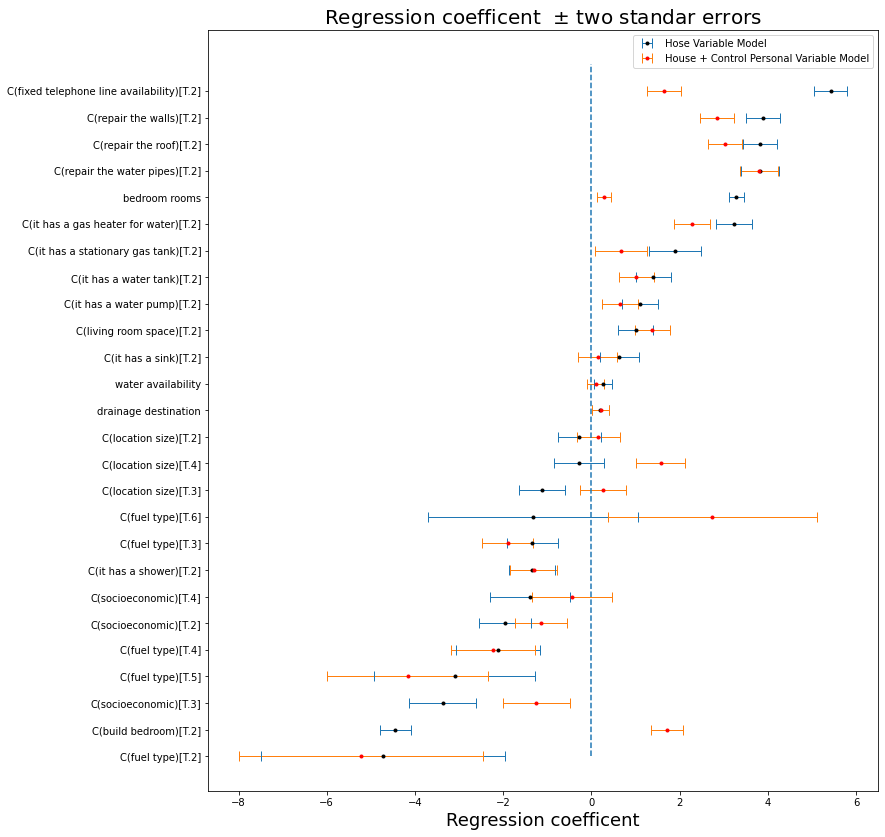

In [32]:
# Plot same variables from two models on same graph
plt.figure(figsize=(12,14))
plt.errorbar(l1[0], np.array(range(len(l1[0]))), xerr= 2*np.array(l3[0]), linewidth = 1,
                 linestyle = 'none',marker = 'o',markersize= 3,
                 markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5,label='Hose Variable Model')
plt.errorbar(l1[1], np.array(range(len(l1[1]))), xerr= 2*np.array(l3[0]), linewidth = 1,
                 linestyle = 'none',marker = 'o',markersize= 3,
                 markerfacecolor = 'red',markeredgecolor = 'red', capsize= 5,label='House + Control Personal Variable Model')
    

plt.vlines(0,0, len(l1[0]), linestyle = '--')

plt.yticks(range(len(l2[0])),l2[0]);
plt.title('Regression coefficent  $\pm$ two standar errors',fontsize=20)
plt.xlabel('Regression coefficent',fontsize=18)
plt.legend()
    